### NOTE: Detailed methodology followed in this analysis is described in this [report](https://github.com/anirudhk686/weather_data_analysis/blob/master/Final_report.pdf)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import os
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

from ipywidgets import interactive, widgets, RadioButtons, ToggleButton, Select, FloatSlider, FloatRangeSlider, IntSlider, fixed

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


sns.set(style='ticks', context='poster')

/home/anirudh/p3/venv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
data_dir = (os.getcwd())+'/data/'
data={'IIG,MUMBAI_BHARATI':data_dir+"iig_bharati2012-16.csv",
'IIG,MUMBAI_MAITRI':data_dir+"iig_maitri2012-15.csv",
'IMD,NEW DELHI_BHARATI':data_dir+"imd_bharati2015-16.csv",
'IMD,NEW DELHI_MAITRI':data_dir+"imd_maitri1985-2016.csv",
'SASE,CHANDIGARH_DOZER,MAITRI':data_dir+"sase_dozer.csv",
'SASE,CHANDIGARH_SANKALP,MAITRI':data_dir+"sase_sankalp.csv"}

path = data['IIG,MUMBAI_MAITRI']
#the analysis is done on maitri data however other files in data folder also can be specified in above path of csv



In [6]:
df=pd.read_csv(path)
index=pd.to_datetime(df.loc[:,'obstime'])
df.index = index
#remove duplicated rows
df=df[~df.index.duplicated()]
start = index[0]
end = index[len(index)-1]
idx = pd.date_range(str(start.year)+'-01-01',str(end.year)+'-12-31',freq='H')
df=df.reindex(idx,fill_value=None)

#filling none values
for col in df:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.interpolate()
#data years
start = 2012
end = 2015

tempr=pd.DataFrame(data=df['tempr'],index=df.index)
tempr_monthly_test = tempr[str(end)+'-05-01':'2015-12-31'].groupby(pd.TimeGrouper('M')).mean()
tempr=tempr[str(start)+'-01-01':str(end)+'-12-31']

#tempr_montly
tempr_monthly = tempr.groupby(pd.TimeGrouper('M')).mean()


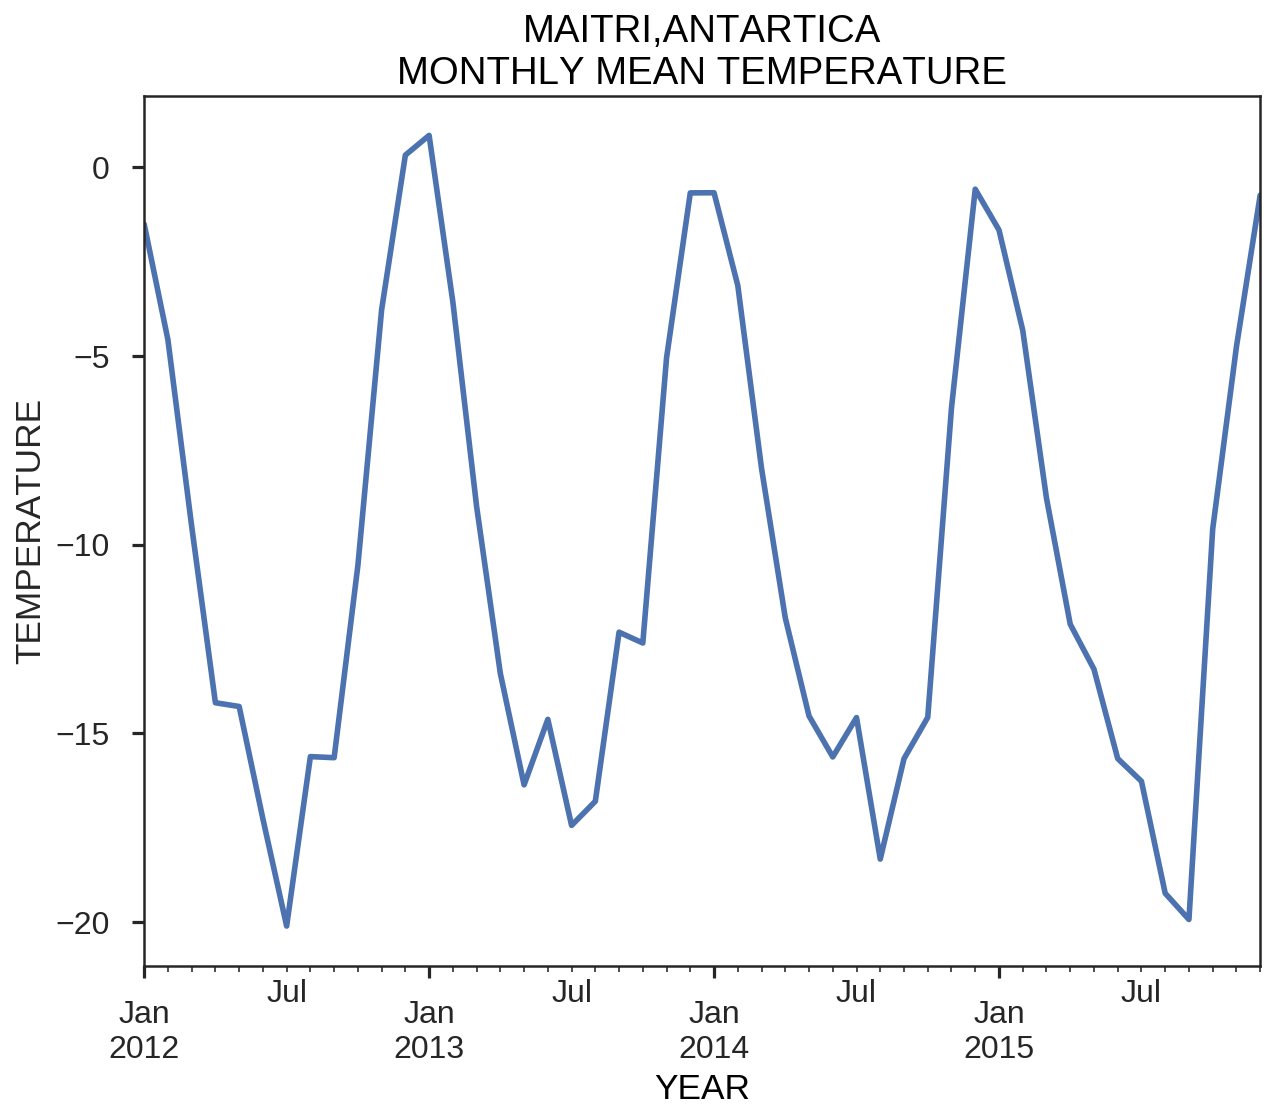

In [7]:
# Examine seasonal trend in the data
grp = tempr.groupby(pd.TimeGrouper('M')).mean()
fig, ax = plt.subplots(figsize=(10,8))
grp['tempr'].plot(ax=ax)
ax.set_xlabel('YEAR', fontdict = { 'color': 'black'});
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('TEMPERATURE')
plt.title('MAITRI'+',ANTARTICA'+'\nMONTHLY MEAN TEMPERATURE', fontdict = { 'color': 'black'} )

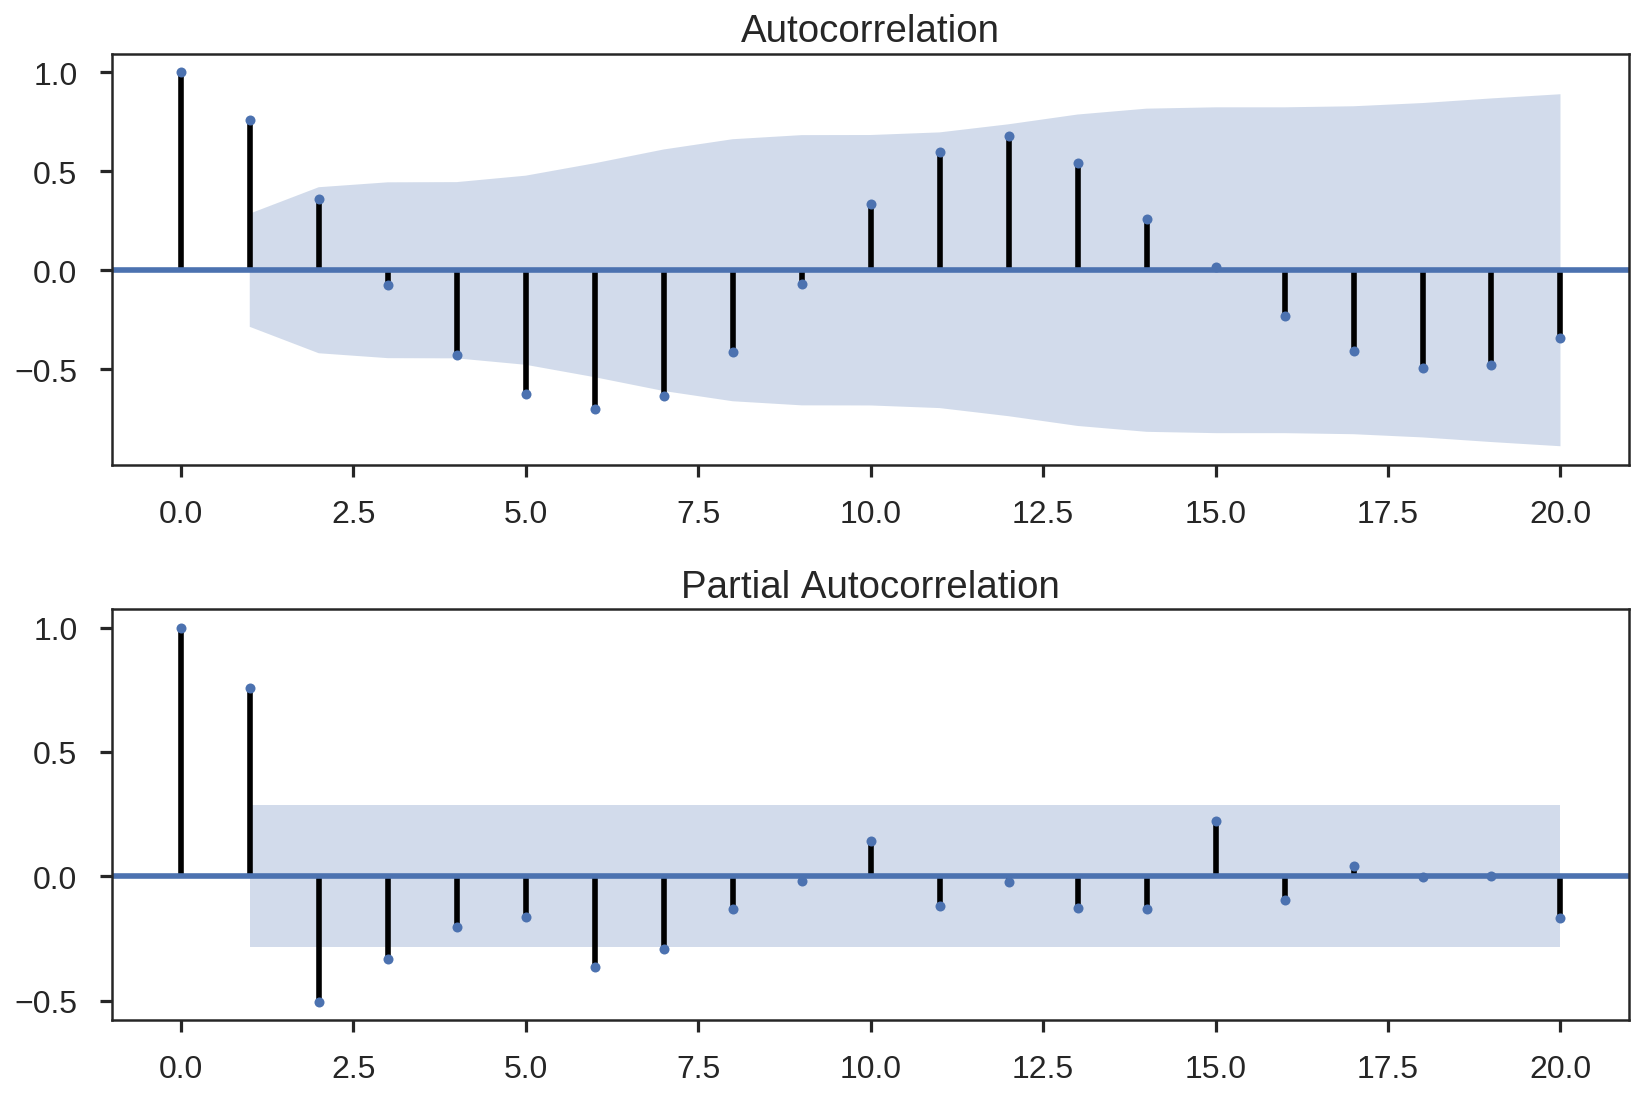

In [8]:
fig = plt.figure(figsize=(12,8))


ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tempr_monthly['tempr'].iloc[1:], lags=20, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(tempr_monthly['tempr'].iloc[1:], lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()

In [9]:

from statsmodels.tsa.stattools import adfuller
X = tempr_monthly['tempr'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.738801
p-value: 0.067561
Critical Values:
	5%: -2.941
	1%: -3.616
	10%: -2.609


In [10]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d= q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = [(0,0, 1)]

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0],x[1], x[2],12) for x in list(itertools.product(p,d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(tempr_monthly['tempr'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            
                                            enforce_invertibility=True)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:154.0965991148557
ARIMA(0, 0, 1)x(0, 2, 0, 12)12 - AIC:120.38591124092429
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:156.07168329576228
ARIMA(0, 0, 1)x(1, 2, 0, 12)12 - AIC:122.368810721637
ARIMA(0, 0, 1)x(2, 1, 0, 12)12 - AIC:148.56877729244053


In [14]:

mod = sm.tsa.statespace.SARIMAX(tempr_monthly['tempr'] ,order=(0,0,1), seasonal_order=(1,2,0,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              tempr   No. Observations:                   48
Model:             SARIMAX(0, 0, 1)x(0, 1, 0, 12)   Log Likelihood                 -75.048
Date:                            Mon, 07 Aug 2017   AIC                            154.097
Time:                                    22:26:06   BIC                            157.839
Sample:                                01-31-2012   HQIC                           155.511
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0160      0.148     -0.109      0.914      -0.305       0.273
sigma2         3.7866      1.029   

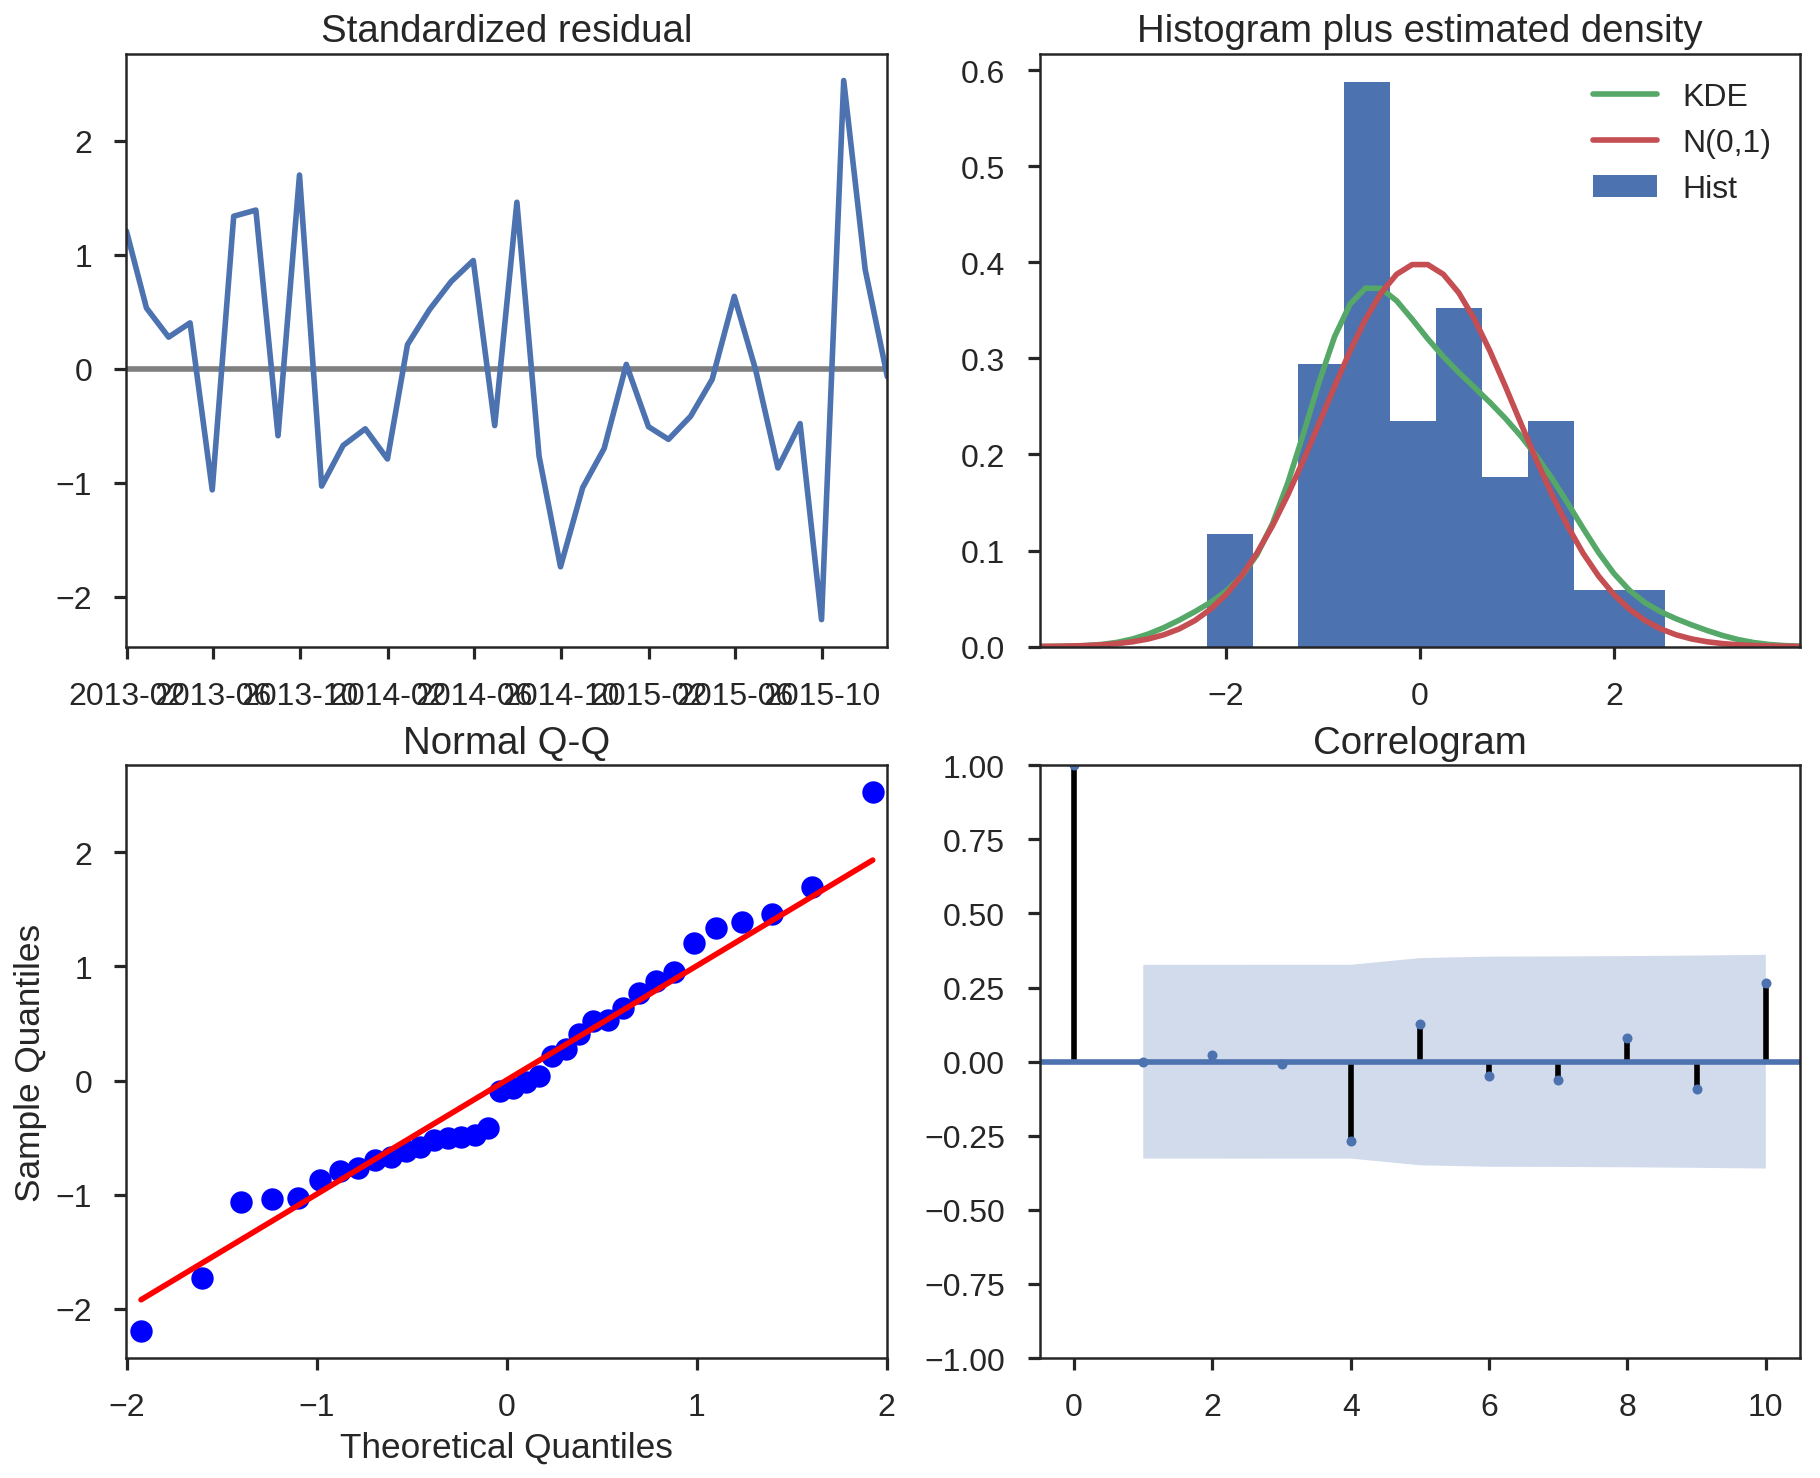

In [17]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

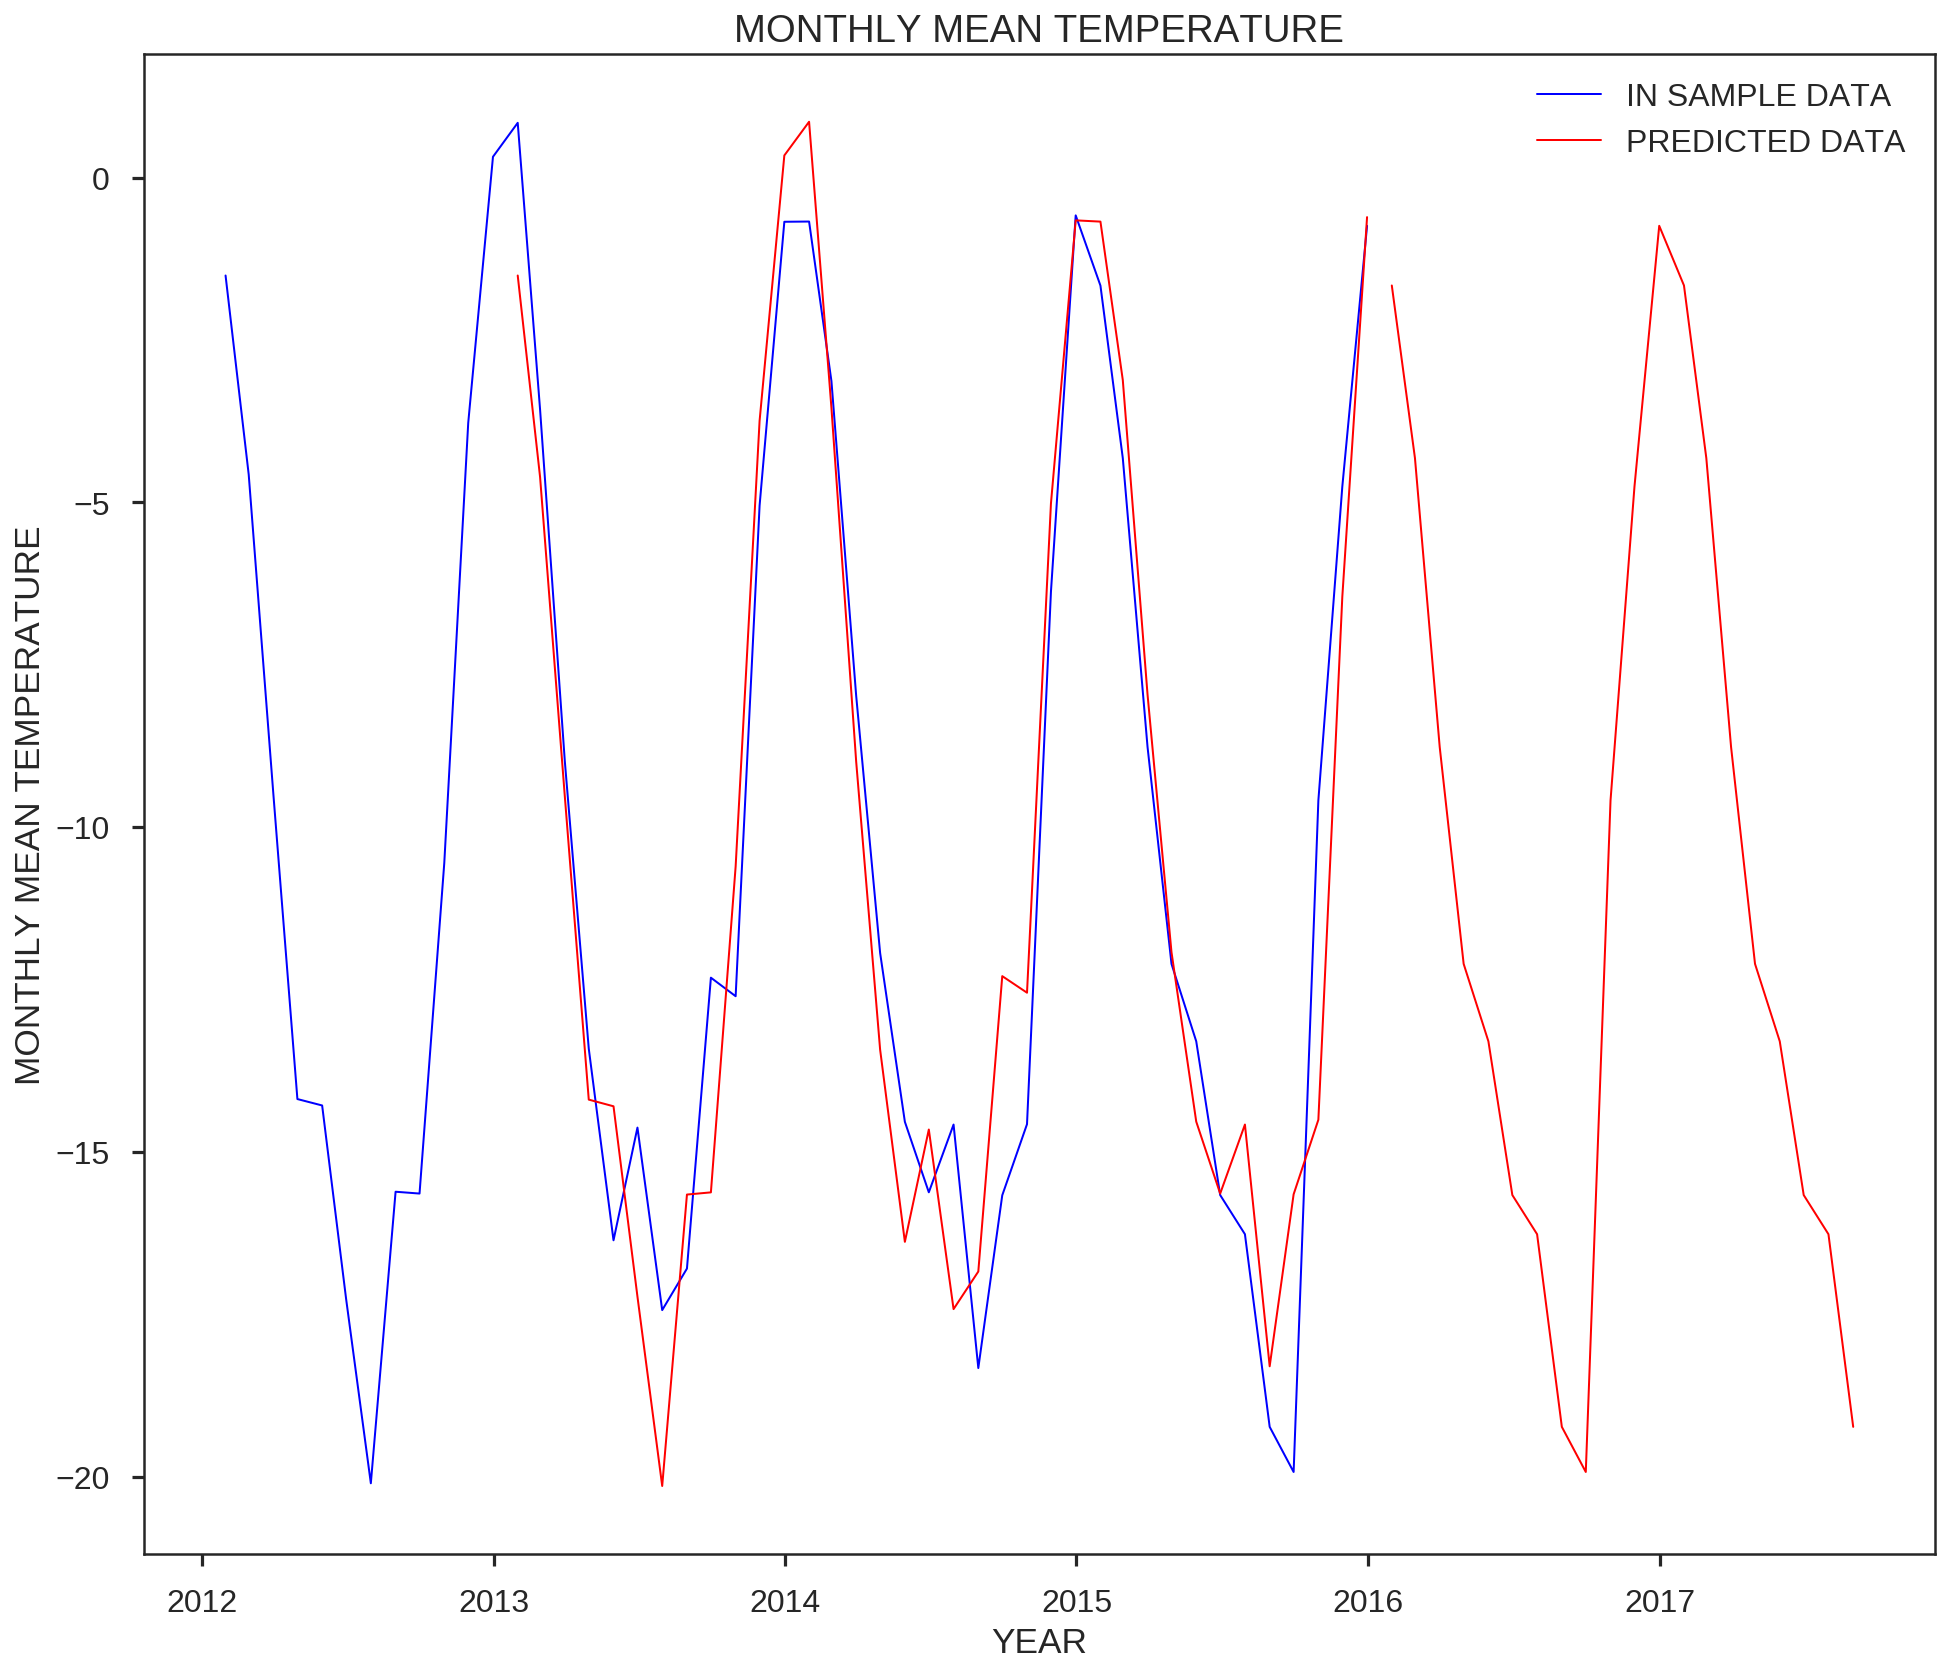

In [16]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14, 12))
    
ax1.plot(tempr_monthly, label='IN SAMPLE DATA', linestyle='-',linewidth = 1,color='b')


pre = results.get_forecast(20)
pre1 = results.get_prediction(12)

ax1.plot(pre.predicted_mean,color = 'r',linewidth = 1,label='PREDICTED DATA')
ax1.plot(pre1.predicted_mean,color = 'r',linewidth = 1)
ax1.set_xlabel("YEAR")
ax1.set_ylabel("MONTHLY MEAN TEMPERATURE")
ax1.legend()
ax1.set_title("MONTHLY MEAN TEMPERATURE")
fig.tight_layout()